In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
day_df = pd.read_pickle('day.pkl')
total_df = pd.read_pickle('total.pkl')

day_complete_df = day_df[:-3]

In [51]:
age_df = total_df[total_df['Åldersgrupp'].notna()]
age_df.assign(Procentuellt_avlidna=age_df['Totalt_antal_avlidna']/age_df['Totalt_antal_fall'])

,Region,Kön,Åldersgrupp,Totalt_antal_fall,Fall_per_100000_inv,Totalt_antal_intensivvårdade,Totalt_antal_avlidna,Procentuellt_avlidna
0,NaN,NaN,Ålder_0_9,49,NaN,1,0,0.000000
1,NaN,NaN,Ålder_10_19,149,NaN,0,0,0.000000
2,NaN,NaN,Ålder_20_29,606,NaN,28,3,0.004950
3,NaN,NaN,Ålder_30_39,771,NaN,29,1,0.001297
4,NaN,NaN,Ålder_40_49,1093,NaN,78,2,0.001830
5,NaN,NaN,Ålder_50_59,1466,NaN,169,28,0.019100
6,NaN,NaN,Ålder_60_69,1174,NaN,204,49,0.041738
7,NaN,NaN,Ålder_70_79,1213,NaN,144,182,0.150041
8,NaN,NaN,Ålder_80_90,1252,NaN,24,280,0.223642
9,NaN,NaN,Ålder_90_plus,637,NaN,1,142,0.222920


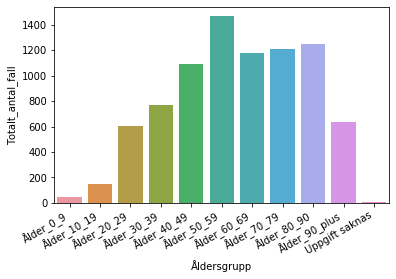

In [57]:
fig = plt.figure()
ax = sns.barplot('Åldersgrupp', 'Totalt_antal_fall', data=age_df)
fig.autofmt_xdate()

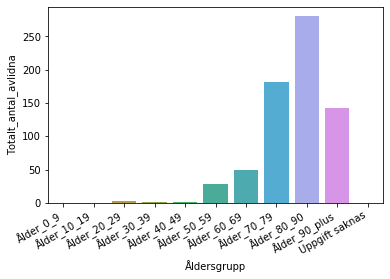

In [60]:
fig = plt.figure()
sns.barplot('Åldersgrupp', 'Totalt_antal_avlidna', data=age_df)
fig.autofmt_xdate()

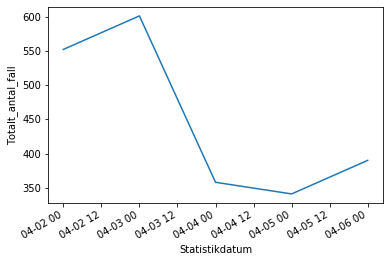

In [61]:
fig = plt.figure()
sns.lineplot('Statistikdatum', 'Totalt_antal_fall', data=day_complete_df[day_complete_df['Statistikdatum'] > '2020-04-01'])
fig.autofmt_xdate()

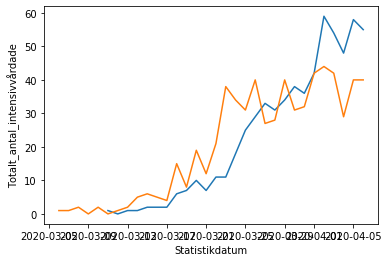

In [32]:
sns.lineplot('Statistikdatum', 'Totalt_antal_avlidna', data=day_complete_df)
sns.lineplot('Statistikdatum', 'Totalt_antal_intensivvårdade', data=day_complete_df)

In [4]:
total_df

,Region,Kön,Åldersgrupp,Totalt_antal_fall,Fall_per_100000_inv,Totalt_antal_intensivvårdade,Totalt_antal_avlidna
0,Blekinge,NaN,NaN,37,23.182085,2,1
1,Dalarna,NaN,NaN,237,82.301384,13,27
2,Gotland,NaN,NaN,14,23.456087,1,0
3,Gävleborg,NaN,NaN,209,72.725502,16,17
4,Halland,NaN,NaN,154,46.128777,12,14
5,Jämtland Härjedalen,NaN,NaN,97,74.153351,3,0
6,Jönköping,NaN,NaN,270,74.257629,24,20
7,Kalmar,NaN,NaN,61,24.852716,7,4
8,Kronoberg,NaN,NaN,61,30.277611,2,1
9,Norrbotten,NaN,NaN,107,42.784084,15,5
